# Correlation

Correlation between each of the features and target. 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [8]:
def structure_data(x_train_obs, x_train_est, x_target):
    split_value = x_train_est['date_forecast'].iloc[0]
    split_index = x_target[x_target['time'] == split_value].index[0]
    x_target_obs = x_target.iloc[:split_index]
    x_target_est = x_target.iloc[split_index:]
    x_train_obs_resampled = x_train_obs.set_index('date_forecast').resample('1H').mean()
    x_train_est_resampled = x_train_est.set_index('date_calc').resample('1H').mean()
    x_train_est_resampled = x_train_est_resampled.drop(columns=['date_forecast'])
    x_target_obs_resampled = x_target_obs.set_index('time').resample('1H').mean()
    x_target_est_resampled = x_target_est.set_index('time').resample('1H').mean()
    return x_train_obs_resampled, x_train_est_resampled, x_target_obs_resampled, x_target_est_resampled

def plot_correlation_matrix(data, title, save_path=None):
    plt.figure(figsize=(16, 10))
    plt.title(title)
    sns.heatmap(data.to_frame(), annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.tight_layout(pad=3)
    if save_path:
        plt.savefig(save_path)
    plt.show()

def create_correlation_matrix(data, target):
    corr_matrix = data.corrwith(target)
    corr_matrix_sorted = corr_matrix.sort_values(ascending=False)
    corr_matrix_sorted = corr_matrix_sorted.dropna()
    corr_matrix_sorted.index = corr_matrix_sorted.index.str.replace(r':(\w+)', r' [\1]', regex=True)
    return corr_matrix_sorted

def process_location_data(target_path, train_obs_path, train_est_path, title_prefix):
    x_target = pd.read_parquet(target_path)
    x_train_obs = pd.read_parquet(train_obs_path)
    x_train_est = pd.read_parquet(train_est_path)
    
    x_train_obs_resampled, x_train_est_resampled, _, x_target_est_resampled = structure_data(x_train_obs, x_train_est, x_target)
    corr_matrix = create_correlation_matrix(x_train_est_resampled, x_target_est_resampled['pv_measurement'])
    
    plot_title = f"{title_prefix} estimated correlation"
    save_path = f"../Mathias/plots/correlations/{plot_title}.png"
    plot_correlation_matrix(corr_matrix, plot_title, save_path)

In [9]:
# Structuring data for later use
x_target_A = pd.read_parquet('../data/A/train_targets.parquet')
x_train_obs_A = pd.read_parquet('../data/A/X_train_observed.parquet')
x_train_est_A = pd.read_parquet('../data/A/X_train_estimated.parquet')
x_train_obs_resampled_A, x_train_est_resampled_A, x_target_obs_resampled_A, x_target_est_resampled_A = structure_data(x_train_obs_A, x_train_est_A, x_target_A)

x_target_B = pd.read_parquet('../data/B/train_targets.parquet')
x_train_obs_B = pd.read_parquet('../data/B/X_train_observed.parquet')
x_train_est_B = pd.read_parquet('../data/B/X_train_estimated.parquet')
x_train_obs_resampled_B, x_train_est_resampled_B, x_target_obs_resampled_B, x_target_est_resampled_B = structure_data(x_train_obs_B, x_train_est_B, x_target_B)

x_target_C = pd.read_parquet('../data/C/train_targets.parquet')
x_train_obs_C = pd.read_parquet('../data/C/X_train_observed.parquet')
x_train_est_C = pd.read_parquet('../data/C/X_train_estimated.parquet')
x_train_obs_resampled_C, x_train_est_resampled_C, x_target_obs_resampled_C, x_target_est_resampled_C = structure_data(x_train_obs_C, x_train_est_C, x_target_C)



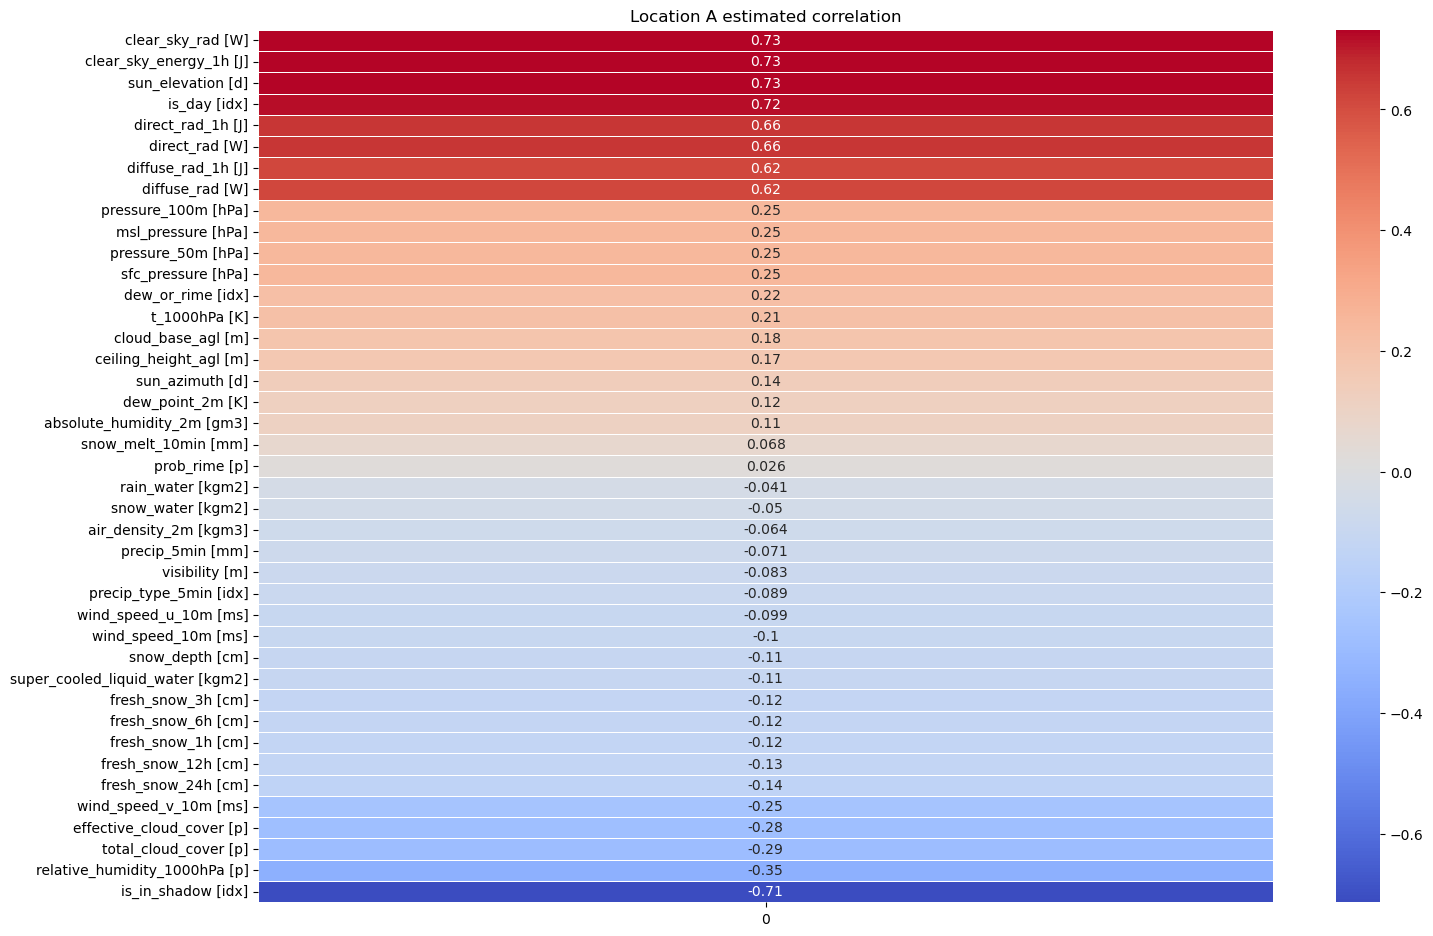

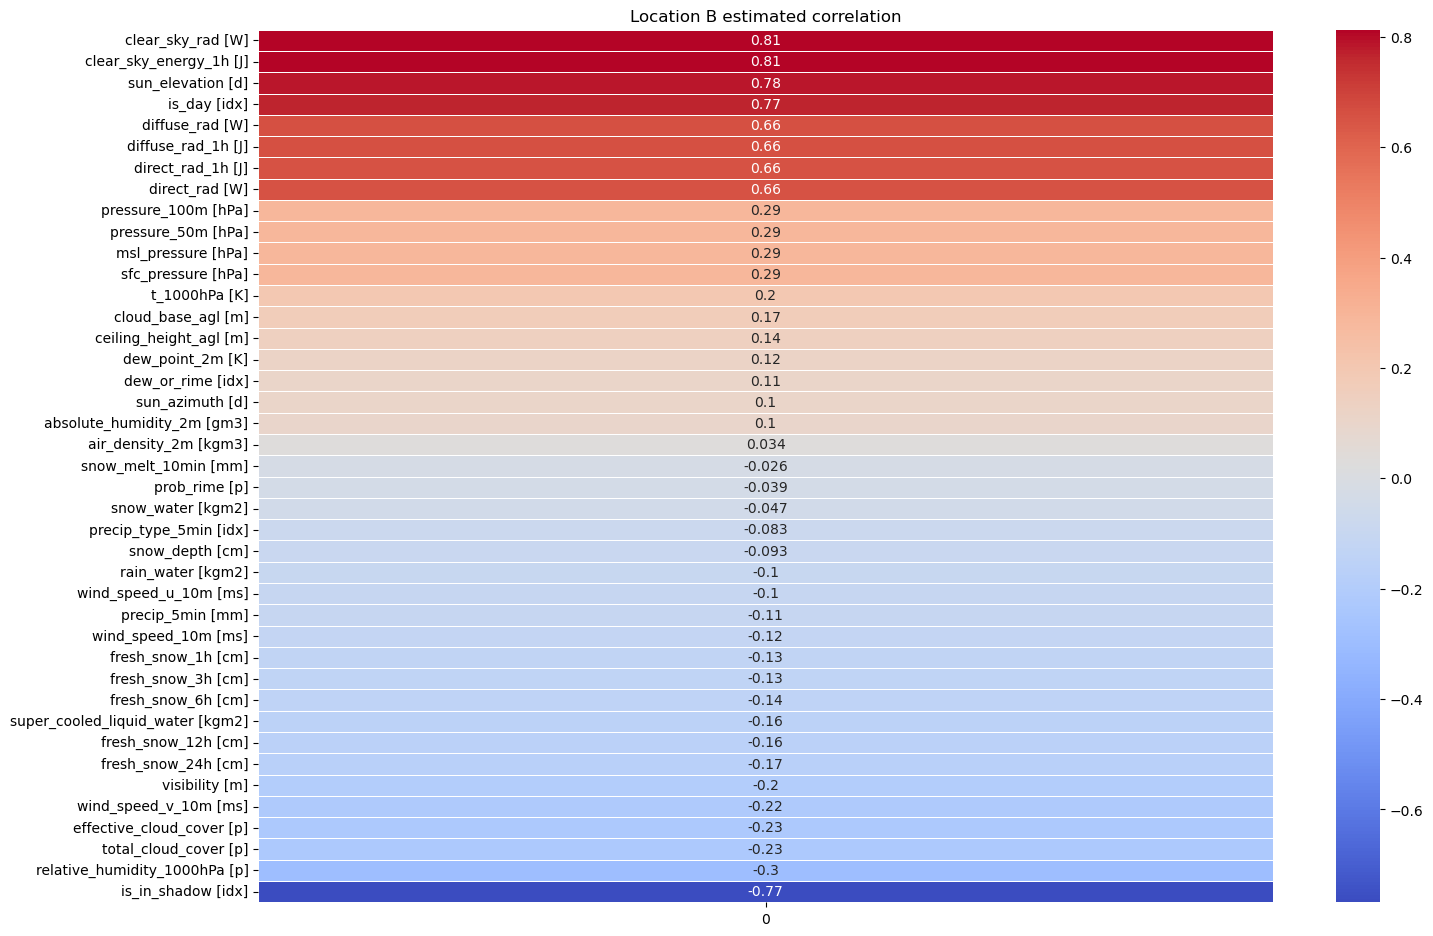

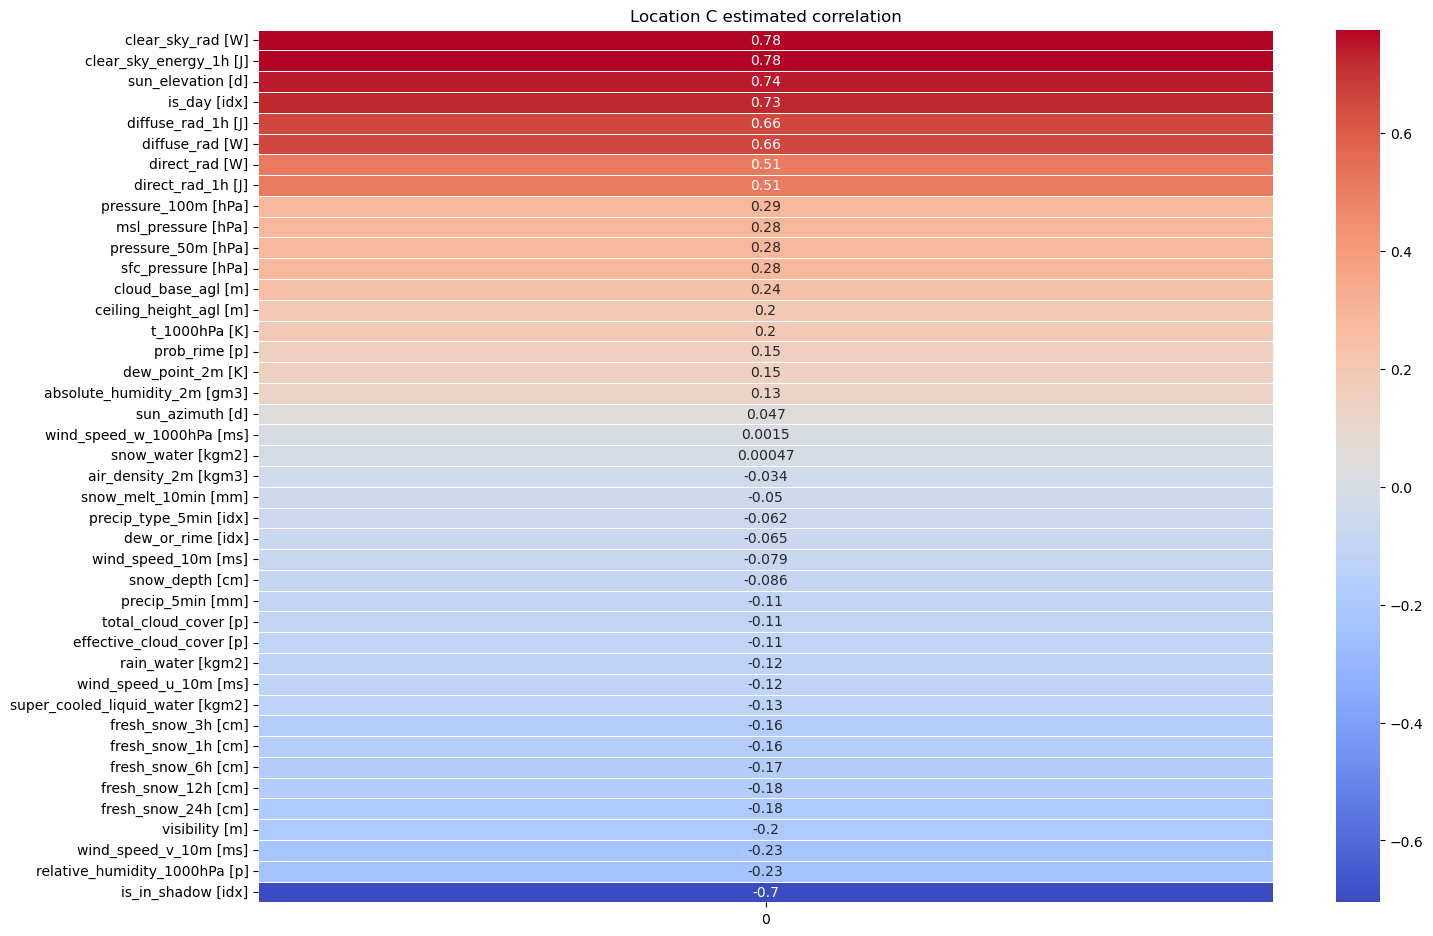

In [10]:
# For Location A
process_location_data("../data/A/train_targets.parquet", 
                      "../data/A/X_train_observed.parquet", 
                      "../data/A/X_train_estimated.parquet", 
                      "Location A")

# For Location B
process_location_data("../data/B/train_targets.parquet", 
                      "../data/B/X_train_observed.parquet", 
                      "../data/B/X_train_estimated.parquet", 
                      "Location B")

# For Location C
process_location_data("../data/C/train_targets.parquet", 
                      "../data/C/X_train_observed.parquet", 
                      "../data/C/X_train_estimated.parquet", 
                      "Location C")

# Cross-Correlation

Cross-correlation is a measure of similarity between two signals or datasets as a function of the time-lag applied to one of them. In simpler terms, it helps us understand how one signal changes in relation to another signal with a time delay (or lag).

### What does it tell us?

1. **Lag**: The position of the peak (positive or negative) in a cross-correlation plot tells us about the time delay (lag) between the two signals. For instance, if the peak is at a positive lag of 2 hours, it means the second signal typically follows the first with a delay of 2 hours.

2. **Strength**: The height of the peak indicates the strength of the correlation. A higher peak means a stronger correlation. The value can range between -1 and 1, where:
   - **1** means perfect positive correlation.
   - **-1** means perfect negative correlation.
   - **0** means no correlation.

3. **Direction**: 
   - A **positive** correlation means that as one signal increases, the other also tends to increase with the given lag.
   - A **negative** correlation means that as one signal increases, the other tends to decrease with the given lag.

### Application in our context:

In the context of solar power prediction, cross-correlation can help us understand how different weather features (like clear sky radiation) influence solar power production. For instance, if the cross-correlation between clear sky radiation and power production peaks at a lag of 1 hour, it suggests that changes in clear sky radiation typically reflect in power production with a delay of 1 hour.


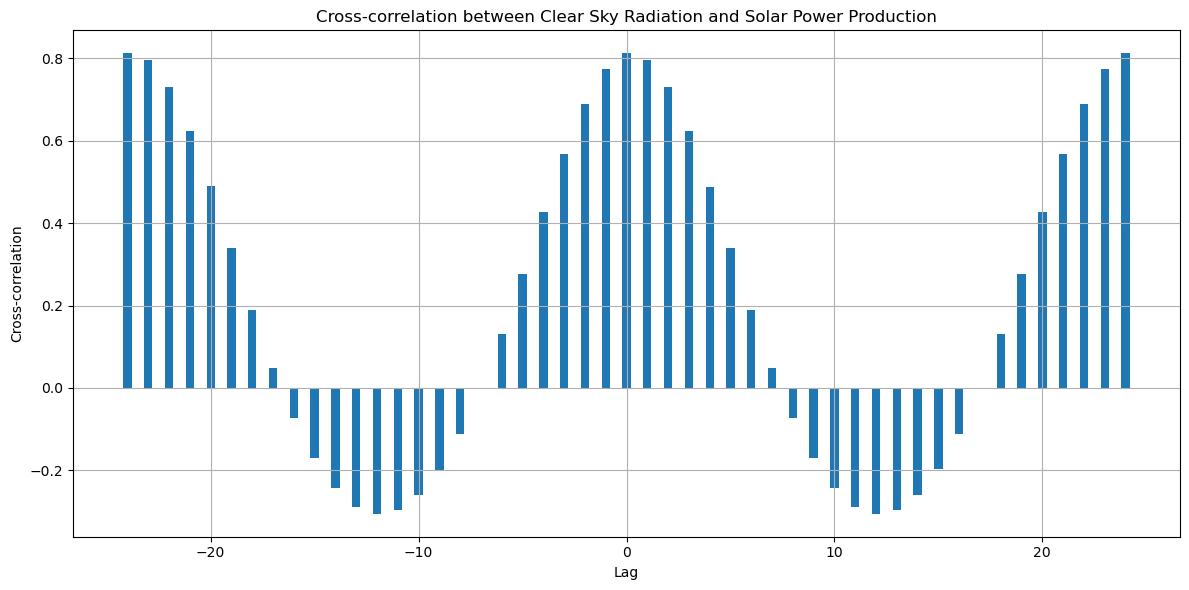

In [11]:
def compute_cross_correlation(series1, series2, max_lag):
    """
    Compute cross-correlation between two series.
    """
    lags = range(-max_lag, max_lag + 1)
    cross_corrs = [series1.corr(series2.shift(lag)) for lag in lags]
    return lags, cross_corrs

def plot_cross_correlation(lags, cross_corrs, title, save_path=None):
    """
    Plot the cross-correlation.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(lags, cross_corrs, width=0.4)
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
    
    plt.show()

# Ensure indices are aligned
aligned_df = pd.merge(x_train_obs_resampled_A[['clear_sky_rad:W']], x_target_obs_resampled_A[['pv_measurement']], left_index=True, right_index=True, how='inner')

# Compute cross-correlation
max_lag = 24  # for example, to check cross-correlation with up to 24 hours lag
lags, cross_corrs = compute_cross_correlation(aligned_df['clear_sky_rad:W'], aligned_df['pv_measurement'], max_lag)

# Plot and save cross-correlation
title_prefix = 'CC clear_sky_rad:W and pv_measurement'
plot_title = f"{title_prefix} estimated correlation"
save_path = f"../Mathias/plots/cross_correlations/{plot_title}.png"
plot_cross_correlation(lags, cross_corrs, 'Cross-correlation between Clear Sky Radiation and Solar Power Production', save_path)




In [12]:

def compute_cross_correlation(series1, series2, max_lag):
    """
    Compute cross-correlation between two series.
    """
    lags = range(-max_lag, max_lag + 1)
    cross_corrs = [series1.corr(series2.shift(lag)) for lag in lags]
    return lags, cross_corrs

def plot_cross_correlation(lags, cross_corrs_list, labels, title, save_path=None, show_plot=False):
    """
    Plot the cross-correlation for multiple datasets with confidence intervals and reference lines.
    """
    plt.figure(figsize=(12, 6))
    
    N = len(lags)  # Number of data points
    z = 1.96  # z-value for 95% confidence interval
    confidence_interval = z * (1 / (N ** 0.5))
    
    for cross_corrs, label in zip(cross_corrs_list, labels):
        cross_corrs_array = np.array(cross_corrs)  # Convert list to numpy array
        plt.plot(lags, cross_corrs_array, label=label)
        plt.fill_between(lags, cross_corrs_array - confidence_interval, cross_corrs_array + confidence_interval, alpha=0.2)
    
    # Create a custom legend entry for the confidence intervals
    conf_patch = mpatches.Patch(color='gray', alpha=0.2, label='95% Confidence Interval')
    
    # Add the custom legend entry to the existing legend
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(conf_patch)
    
    plt.legend(handles=handles)
    
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    # Improve x-axis ticks and labels
    plt.xticks(lags[::2])  # Show every second tick for clarity
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)  # Add a vertical line at lag=0 for reference
    
    # Add reference lines for specific threshold values
    plt.axhline(0.5, color='red', linestyle='--', linewidth=0.5)
    plt.axhline(-0.5, color='red', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
    
    if show_plot:
        plt.show()

    plt.close()



def analyze_cross_correlation(feature_name, show_plot=False):
    max_lag = 24  # for example, to check cross-correlation with up to 24 hours lag

    datasets = {
        'A': (x_train_obs_resampled_A, x_target_obs_resampled_A),
        'B': (x_train_obs_resampled_B, x_target_obs_resampled_B),
        'C': (x_train_obs_resampled_C, x_target_obs_resampled_C)
    }

    cross_corrs_list = []
    labels = []

    for location, (x_train, x_target) in datasets.items():
        aligned_df = pd.merge(x_train[[feature_name]], x_target[['pv_measurement']], left_index=True, right_index=True, how='inner')
        lags, cross_corrs = compute_cross_correlation(aligned_df[feature_name], aligned_df['pv_measurement'], max_lag)
        cross_corrs_list.append(cross_corrs)
        labels.append(f'Location {location}')

    # Plot and save cross-correlation
    plot_title = f"CC {feature_name} and pv_measurement estimated correlation"
    save_path = f"../Mathias/plots/cross_correlations/{plot_title}.png"
    plot_cross_correlation(lags, cross_corrs_list, labels, f'Cross-correlation between {feature_name} and Solar Power Production', save_path, show_plot=show_plot)

# Example usage:
# Columns 
'''
'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
'wind_speed_w_1000hPa:ms'
'''
analyze_cross_correlation('clear_sky_rad:W', show_plot=False)
analyze_cross_correlation('is_in_shadow:idx', show_plot=False)
analyze_cross_correlation('clear_sky_energy_1h:J', show_plot=False)
analyze_cross_correlation('sun_elevation:d', show_plot=False)
analyze_cross_correlation('is_day:idx', show_plot=False)
analyze_cross_correlation('diffuse_rad_1h:J', show_plot=False)
analyze_cross_correlation('diffuse_rad:W', show_plot=False)
analyze_cross_correlation('direct_rad:W', show_plot=False)
analyze_cross_correlation('direct_rad_1h:J', show_plot=False)
analyze_cross_correlation('sun_azimuth:d', show_plot=False)
analyze_cross_correlation('effective_cloud_cover:p', show_plot=False)
analyze_cross_correlation('total_cloud_cover:p', show_plot=False)
analyze_cross_correlation('cloud_base_agl:m', show_plot=False)
analyze_cross_correlation('ceiling_height_agl:m', show_plot=False)
analyze_cross_correlation('visibility:m', show_plot=False)
analyze_cross_correlation('rain_water:kgm2', show_plot=False)
analyze_cross_correlation('snow_water:kgm2', show_plot=False)
analyze_cross_correlation('snow_depth:cm', show_plot=False)
analyze_cross_correlation('snow_melt_10min:mm', show_plot=False)
analyze_cross_correlation('snow_drift:idx', show_plot=False)
analyze_cross_correlation('snow_density:kgm3', show_plot=False)
analyze_cross_correlation('super_cooled_liquid_water:kgm2', show_plot=False)
analyze_cross_correlation('fresh_snow_1h:cm', show_plot=False)
analyze_cross_correlation('fresh_snow_3h:cm', show_plot=False)
analyze_cross_correlation('fresh_snow_6h:cm', show_plot=False)
analyze_cross_correlation('fresh_snow_12h:cm', show_plot=False)
analyze_cross_correlation('fresh_snow_24h:cm', show_plot=False)
analyze_cross_correlation('prob_rime:p', show_plot=False)
analyze_cross_correlation('dew_point_2m:K', show_plot=False)
analyze_cross_correlation('air_density_2m:kgm3', show_plot=False)
analyze_cross_correlation('relative_humidity_1000hPa:p', show_plot=False)
analyze_cross_correlation('t_1000hPa:K', show_plot=False)
analyze_cross_correlation('pressure_100m:hPa', show_plot=False)
analyze_cross_correlation('pressure_50m:hPa', show_plot=False)
analyze_cross_correlation('sfc_pressure:hPa', show_plot=False)
analyze_cross_correlation('wind_speed_10m:ms', show_plot=False)
analyze_cross_correlation('wind_speed_u_10m:ms', show_plot=False)
analyze_cross_correlation('wind_speed_v_10m:ms', show_plot=False)
analyze_cross_correlation('wind_speed_w_1000hPa:ms', show_plot=False)
analyze_cross_correlation('absolute_humidity_2m:gm3', show_plot=False)
analyze_cross_correlation('precip_5min:mm', show_plot=False)
analyze_cross_correlation('precip_type_5min:idx', show_plot=False)
analyze_cross_correlation('dew_or_rime:idx', show_plot=False)



